In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, Dropout, MaxPool2D, SeparableConv2D, Conv2DTranspose,concatenate
from keras.layers import MaxPooling2D, BatchNormalization
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from IPython.display import  display
from PIL import Image
import random
import cv2
import time 
from keras import backend as K
%matplotlib inline

In [65]:
#Helpful Tutorial



#https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e


In [ ]:
BatchNormalization()

In [3]:
class conv_block(keras.layers.Layer):
    def __init__(self,features,  rate, kernel = (3,3), pool_kernel = (2,2), activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal'):
        super(conv_block, self).__init__()
        
  
    
      
        self.conv1= Conv2D(features, kernel, activation =  activation,padding = padding, kernel_initializer = kernel_initializer)
        self.dropout1= Dropout(rate)
        self.conv2= Conv2D(features, kernel, activation =  activation,padding = padding, kernel_initializer = kernel_initializer)
        self.maxpool1 = MaxPool2D(pool_kernel, padding=padding )
        
    def call(self, input_tensor):
            
            conv1 = self.conv1(input_tensor)
        
            conv1 = self.dropout1(conv1)
             
            conv1 = self.conv2(conv1)
            
            pool1 = self.maxpool1(conv1)
  
            return conv1, pool1
            
            

In [4]:
class separable_conv_block(keras.layers.Layer):
    def __init__(self,features, rate, kernel = (3,3), pool_kernel = (2,2), activation = 'relu', padding = 'same'
                     , depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(separable_conv_block, self).__init__()
     
        
  
        
        self.s_conv1= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.dropout2= Dropout(rate)
        self.s_conv2= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.maxpool2 =  MaxPool2D(pool_kernel, padding=padding )
        
    def call(self, inputs):
     
        
            conv2 = self.s_conv1(inputs)
 
            conv2 = self.dropout2(conv2)

            conv2 = self.s_conv2(conv2)
             
            pool2 = self.maxpool2(conv2)
           
            return conv2,pool2
            
            

In [5]:
class out_sep_conv_block(keras.layers.Layer):
    def __init__(self,features, rate, kernel = (3,3), activation = 'relu', padding = 'same'
                     , depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(out_sep_conv_block, self).__init__()
     

        
        self.s_conv3= SeparableConv2D(features, kernel, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.dropout3 = Dropout(rate)
        self.s_conv4= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)

        
    def call(self, inputs):
          
            conv3 = self.s_conv3(inputs)
      
            conv3 = self.dropout3(conv3)
           
            conv3 = self.s_conv4(conv3)
        
            
            return conv3
            

In [6]:
class conv_transpose(keras.layers.Layer):
    def __init__(self,features, rate,kernel_1 = (2,2), strides = (2,2), kernel_2 = (3,3), activation = 'relu', padding = 'same'
                     ,depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(conv_transpose, self).__init__()
        
 
        
        self.conv_trans= Conv2DTranspose( features, kernel_1, strides = strides, padding =padding)
        self.sep_conv1 = SeparableConv2D(features, kernel_2, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.drop = Dropout(rate)
        self.sep_conv2 = SeparableConv2D(features,kernel_2, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.cat = tf.keras.layers.Concatenate()
    def call(self, inputs_1, inputs_2):
           
        
            up_conv = self.conv_trans(inputs_1)
       
            up_conv = self.cat([up_conv, inputs_2])
          
            conv4 = self.sep_conv1(up_conv)
            
            conv4 = self.drop(conv4)
   
            conv4 = self.sep_conv2(conv4)
        
    
            return conv4

In [7]:
class U_Encoder(keras.Model):
    def __init__(self, num_classes, activation = 'sigmoid'):
        super(U_Encoder, self).__init__()
       # self.inputs = inputs
        self.num_classes = num_classes
        self.conv1 =  conv_block(16, 0.1)
        self.conv2 =  separable_conv_block(32, 0.1)
        self.conv3 =  separable_conv_block(64, 0.2)
        self.conv4 =  separable_conv_block(128, 0.2)
        
        self.out_conv =  out_sep_conv_block(256, 0.1)
        
        self.up_conv1 = conv_transpose(128,0.2)
        self.up_conv2 = conv_transpose(64,0.2)
        self.up_conv3 = conv_transpose(32,0.1)
        self.up_conv4 = conv_transpose(16,0.1)
        
        #self.outp = Conv2D(num_classes,(1,1), activation = 'softmax'), Wnet version 
        
        self.out_layer = Conv2D(num_classes,(1,1), activation = activation) #Normal Unet version for testing.
       
      
        
        
    def call(self, inputs):
        

        
        con1,pol1 = self.conv1(inputs)
         
   
        con2,pol2 = self.conv2(pol1)
       
        con3,pol3 = self.conv3(pol2)
     
        con4,pol4 = self.conv4(pol3)
       
        con5 = self.out_conv(pol4)

        con6 = self.up_conv1(con5, con4)

        con7 = self.up_conv2(con6, con3)

        con8 = self.up_conv3(con7, con2)

        
        con9 = self.up_conv4(con8, con1)
       
        out = self.out_layer(con9)
    

        return out
        
        
        

In [8]:
def training_images():
    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img  #Fill empty X_train with values from img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)  
            
        Y_train[n] = mask 
    return X_train, Y_train 

In [9]:
# test images
def test_images():
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Resizing test images') 
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    return X_test



In [11]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

#train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids = next(os.walk(TEST_PATH))[1]

#X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#X_train, Y_train = training_images()
#X_test = test_images()


#np.save('X_train.npy', X_train) 
#np.save('X_test.npy', X_test) # .npy extension is added if not given
#np.save('Y_train.npy', Y_train)

X = np.load('X_train.npy') 
X_t = np.load('X_test.npy') # .npy extension is added if not given
Y = np.load('Y_train.npy')

X_train = X.astype('float32') / 255
X_t = X_t.astype('float32') / 255

In [12]:
##### Unet Module.

stime = time.time()

#inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) # Image Shape (width, height, depth)\
# is there really a need to define the input layer, maybe you can just define it in the conv layer, try that later.

#inp = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#inputs= keras.layers.Lambda(lambda X_train: X_train/255)




model = U_Encoder(1)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])



checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only=True)

callbacks  = [keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'), 
              keras.callbacks.TensorBoard(log_dir= 'logs')]

results = model.fit(X_train,Y, validation_split = 0.1, batch_size = 16, epochs = 25)
print("Total Time Taken is ", (time.time()-stime)/60)

Epoch 1/25
38/38 [==============================] - 45s 1s/step - loss: 0.6791 - accuracy: 0.7251 - val_loss: 0.5896 - val_accuracy: 0.8146
Epoch 2/25
38/38 [==============================] - 40s 1s/step - loss: 0.5464 - accuracy: 0.7978 - val_loss: 0.4329 - val_accuracy: 0.8146
Epoch 3/25
38/38 [==============================] - 41s 1s/step - loss: 0.4457 - accuracy: 0.8007 - val_loss: 0.3486 - val_accuracy: 0.8146
Epoch 4/25
38/38 [==============================] - 41s 1s/step - loss: 0.3530 - accuracy: 0.8220 - val_loss: 0.2842 - val_accuracy: 0.8882
Epoch 5/25
38/38 [==============================] - 43s 1s/step - loss: 0.2919 - accuracy: 0.8881 - val_loss: 0.2905 - val_accuracy: 0.8793
Epoch 6/25
38/38 [==============================] - 40s 1s/step - loss: 0.2678 - accuracy: 0.8967 - val_loss: 0.2690 - val_accuracy: 0.8899
Epoch 7/25
38/38 [==============================] - 41s 1s/step - loss: 0.2562 - accuracy: 0.8989 - val_loss: 0.2045 - val_accuracy: 0.9196
Epoch 8/25
38/38 [==

In [13]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_t, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 400ms/step


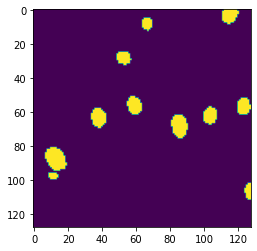

In [15]:
plt.imshow(preds_test_t[0])

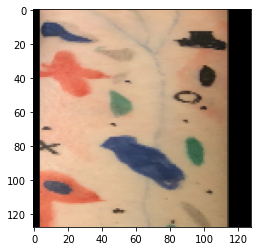

In [24]:

img = cv2.imread("IMG1_cut.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128,128))
plt.imshow(img)

In [26]:
im

(128, 128, 3)

In [25]:
preds_test = model.predict(img, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ValueError: in user code:

    /Users/mariam/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1446 predict_function  *
        return step_function(self, iterator)
    <ipython-input-7-3a474d74c068>:29 call  *
        con1,pol1 = self.conv1(inputs)
    <ipython-input-3-a9f57efa4dc5>:16 call  *
        conv1 = self.conv1(input_tensor)
    /Users/mariam/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:979 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/mariam/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, None, 3)
